In [0]:
import time
import pandas as pd
import json
from pyspark.sql.functions import *

In [0]:
spark.sql("USE CATALOG hive_metastore")
spark.sql("USE default")

print("="*70)
print("ENVIRONMENT SETUP")
print("="*70)
print(f"✓ Current Catalog: {spark.sql('SELECT current_catalog()').collect()[0][0]}")
print(f"✓ Current Database: {spark.sql('SELECT current_database()').collect()[0][0]}")
print(f"✓ Spark version: {spark.version}")
print("="*70)

ENVIRONMENT SETUP
✓ Current Catalog: hive_metastore
✓ Current Database: default
✓ Spark version: 4.0.0


In [0]:
# ============================================
# Setup
# ============================================

print("="*70)
print("HORIZONTAL SCALING BENCHMARKS")
print("DS FEATURE: Demonstrating scalability with cluster size")
print("="*70)

# Results storage
benchmark_results = {
    "data_processing": [],
    "ml_training": []
}

print("\nSetup complete")
print("Ready to benchmark with current cluster configuration")

HORIZONTAL SCALING BENCHMARKS
DS FEATURE: Demonstrating scalability with cluster size

Setup complete
Ready to benchmark with current cluster configuration


In [0]:
# ============================================
# Data Processing Benchmark Function
# ============================================

from pyspark.sql.functions import count as spark_count, avg, sum as spark_sum, col, when
import time
import builtins  # Python's built-in functions

def benchmark_data_processing(num_workers, run_name):
    """
    Benchmark distributed data processing operations
    Tests: Full scan, aggregation, transformation, join
    OPTIMIZED: 10% sample for faster execution
    """
    print(f"\n{'='*70}")
    print(f"DATA PROCESSING BENCHMARK: {num_workers} workers")
    print(f"{'='*70}")
    
    results = {
        "run_name": run_name,
        "num_workers": num_workers,
        "operations": {}
    }
    
    # Operation 1: Full table scan (10% sample)
    print("\n[1/4] Table scan (10% sample)...")
    df = spark.table("taxi_trips").sample(0.1, seed=42)
    start = time.time()
    row_count = df.count()
    results["operations"]["full_scan"] = time.time() - start
    print(f"Counted {row_count:,} rows in {results['operations']['full_scan']:.2f}s")
    
    # Operation 2: Aggregation by month
    print("\n[2/4] GROUP BY aggregation...")
    start = time.time()
    agg_result = df.groupBy("month").agg(
        spark_count("*").alias("trip_count"),
        avg("trip_duration_minutes").alias("avg_duration"),
        avg("trip_distance").alias("avg_distance"),
        spark_sum("fare_amount").alias("total_revenue")
    ).collect()
    results["operations"]["aggregation"] = time.time() - start
    print(f"Aggregated {len(agg_result)} groups in {results['operations']['aggregation']:.2f}s")
    
    # Operation 3: Complex transformation
    print("\n[3/4] Complex transformations...")
    start = time.time()
    transformed = df.withColumn(
        "efficiency_score",
        col("trip_distance") / (col("trip_duration_minutes") / 60) * col("fare_amount")
    ).withColumn(
        "time_of_day",
        when(col("hour_of_day").between(6, 11), "Morning")
        .when(col("hour_of_day").between(12, 17), "Afternoon")
        .when(col("hour_of_day").between(18, 22), "Evening")
        .otherwise("Night")
    )
    # Force execution
    transformed.write.format("noop").mode("overwrite").save()
    results["operations"]["transformation"] = time.time() - start
    print(f"Transformed {row_count:,} rows in {results['operations']['transformation']:.2f}s")
    
    # Operation 4: Join operation (1% sample)
    print("\n[4/4] Self-join operation (1% sample)...")
    df_sample = df.sample(0.01, seed=42)
    start = time.time()
    joined = df_sample.alias("a").join(
        df_sample.alias("b"),
        col("a.PULocationID") == col("b.DOLocationID"),
        "inner"
    )
    join_row_count = joined.count()
    results["operations"]["join"] = time.time() - start
    print(f"Join completed in {results['operations']['join']:.2f}s ({join_row_count:,} rows)")
    
    # Calculate total time - USE PYTHON'S BUILT-IN SUM EXPLICITLY
    results["total_time"] = builtins.sum(results["operations"].values())
    
    print(f"\n{'='*70}")
    print(f"TOTAL TIME: {results['total_time']:.2f} seconds")
    print(f"{'='*70}")
    
    return results



In [0]:
# ============================================
# Benchmark with 2 Workers
# ============================================

print("\nStarting benchmark with CURRENT cluster configuration...")

# Run benchmark
result_2w = benchmark_data_processing(
    num_workers=2,
    run_name="2_workers_baseline"
)

# Store results
benchmark_results["data_processing"].append(result_2w)

print(f"\nBaseline benchmark complete with 2 workers")
print(f"Total time: {result_2w['total_time']:.2f} seconds")

# Save intermediate results using dbutils
results_json = json.dumps(benchmark_results, indent=2)
dbutils.fs.put(
    "/mnt/taxi-data/benchmarks/intermediate_results.json",
    results_json,
    overwrite=True
)

print("\nResults saved to /mnt/taxi-data/benchmarks/")


Starting benchmark with CURRENT cluster configuration...

DATA PROCESSING BENCHMARK: 2 workers

[1/4] Table scan (10% sample)...
Counted 5,311,315 rows in 0.40s

[2/4] GROUP BY aggregation...
Aggregated 12 groups in 0.65s

[3/4] Complex transformations...
Transformed 5,311,315 rows in 1.68s

[4/4] Self-join operation (1% sample)...
Join completed in 1.52s (63,846,367 rows)

TOTAL TIME: 4.26 seconds

Baseline benchmark complete with 2 workers
Total time: 4.26 seconds
Wrote 671 bytes.

Results saved to /mnt/taxi-data/benchmarks/


In [0]:
# ============================================
# Benchmark with 4 Workers (After Resize)
# ============================================

# print("\nVerifying cluster configuration...")
# print("Expected: 4 workers active\n")

# input("Confirm cluster has 4 workers, then press Enter to continue...")

# Run benchmark with 4 workers
result_4w = benchmark_data_processing(
    num_workers=4,
    run_name="4_workers_scaled"
)

# Store results
benchmark_results["data_processing"].append(result_4w)

# Calculate speedup
baseline_time = result_2w["total_time"]
scaled_time = result_4w["total_time"]
speedup = baseline_time / scaled_time
efficiency = (speedup / 2) * 100  # 2x increase in workers

print("\n" + "="*70)
print("SCALABILITY ANALYSIS - DATA PROCESSING")
print("="*70)
print(f"\n2 Workers: {baseline_time:.2f} seconds")
print(f"4 Workers: {scaled_time:.2f} seconds")
print(f"\nSpeedup: {speedup:.2f}x")
print(f"Ideal Speedup: 2.00x (linear)")
print(f"Parallel Efficiency: {efficiency:.1f}%")

if efficiency >= 85:
    print("\nEXCELLENT: Near-linear scalability achieved!")
elif efficiency >= 70:
    print("\nGOOD: Strong scalability")
else:
    print("\nModerate scalability")

print("="*70)

# Save results
results_json = json.dumps(benchmark_results["data_processing"], indent=2)
dbutils.fs.put(
    "/mnt/taxi-data/benchmarks/data_processing_scalability.json",
    results_json,
    overwrite=True
)

print("\nData processing benchmarks complete")
print("Results saved")


DATA PROCESSING BENCHMARK: 4 workers

[1/4] Table scan (10% sample)...
Counted 5,307,621 rows in 0.54s

[2/4] GROUP BY aggregation...
Aggregated 12 groups in 0.87s

[3/4] Complex transformations...
Transformed 5,307,621 rows in 2.27s

[4/4] Self-join operation (1% sample)...
Join completed in 1.13s (63,304,855 rows)

TOTAL TIME: 4.81 seconds

SCALABILITY ANALYSIS - DATA PROCESSING

2 Workers: 4.26 seconds
4 Workers: 4.81 seconds

Speedup: 0.89x
Ideal Speedup: 2.00x (linear)
Parallel Efficiency: 44.3%

Moderate scalability
Wrote 2293 bytes.

Data processing benchmarks complete
Results saved


In [0]:
# ============================================
# ML Training Benchmark Function
# ============================================

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

def benchmark_ml_training(num_workers, num_trees, run_name):
    """
    Benchmark distributed Random Forest training
    DS FEATURE: Data parallelism in ML training
    """
    print(f"\n{'='*70}")
    print(f"ML TRAINING BENCHMARK: {num_workers} workers, {num_trees} trees")
    print(f"{'='*70}")
    
    # Load data
    train = spark.table("taxi_ml_train")
    test = spark.table("taxi_ml_test")
    
    # Ensure cached
    train.cache().count()
    test.cache().count()
    
    print(f"\nDistributed Training Configuration:")
    print(f"  Total trees: {num_trees}")
    print(f"  Workers: {num_workers}")
    print(f"  Trees per worker: ~{num_trees // num_workers}")
    print(f"  Training method: Data parallelism")
    print(f"  Each worker: Trains subset of trees independently")
    
    # Train Random Forest
    start_time = time.time()
    
    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol="trip_duration_minutes",
        numTrees=num_trees,
        maxDepth=7,
        seed=42
    )
    
    print(f"\nTraining {num_trees} trees...")
    model = rf.fit(train)
    training_time = time.time() - start_time
    
    # Evaluate
    print("Evaluating model...")
    predictions = model.transform(test)
    evaluator = RegressionEvaluator(
        labelCol="trip_duration_minutes",
        metricName="rmse"
    )
    rmse = evaluator.evaluate(predictions)
    
    result = {
        "run_name": run_name,
        "num_workers": num_workers,
        "num_trees": num_trees,
        "training_time": training_time,
        "rmse": rmse
    }
    
    print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.1f} minutes)")
    print(f"RMSE: {rmse:.2f} minutes")
    print("="*70)
    
    return result

# print("ML benchmark function defined")

In [0]:
# ============================================
# ML Training Benchmark - 2 Workers
# ============================================

print("\nML Training Benchmark: 2 workers, 10 trees")

# Run benchmark
ml_result_2w = benchmark_ml_training(
    num_workers=2,
    num_trees=10,
    run_name="ml_2w_10trees"
)

# Store results
benchmark_results["ml_training"].append(ml_result_2w)

print(f"\nBaseline ML benchmark complete: {ml_result_2w['training_time']:.2f}s")

# Save intermediate
ml_results_json = json.dumps(benchmark_results["ml_training"], indent=2)
dbutils.fs.put(
    "/mnt/taxi-data/benchmarks/intermediate_ml_results.json",
    ml_results_json,
    overwrite=True
)


ML Training Benchmark: 2 workers, 10 trees

ML TRAINING BENCHMARK: 2 workers, 10 trees

Distributed Training Configuration:
  Total trees: 10
  Workers: 2
  Trees per worker: ~5
  Training method: Data parallelism
  Each worker: Trains subset of trees independently

Training 10 trees...
Evaluating model...

Training completed in 402.06 seconds (6.7 minutes)
RMSE: 5.31 minutes

Baseline ML benchmark complete: 402.06s
Wrote 158 bytes.


True

In [0]:
# ============================================
# ML Training Benchmark - 4 Workers
# ============================================

print("\nML Training Benchmark: 4 workers, 10 trees")

# Run benchmark with 4 workers
ml_result_4w = benchmark_ml_training(
    num_workers=4,
    num_trees=10,
    run_name="ml_4w_10trees"
)

# Store results
benchmark_results["ml_training"].append(ml_result_4w)

# Calculate ML speedup
ml_baseline = ml_result_2w["training_time"]
ml_scaled = ml_result_4w["training_time"]
ml_speedup = ml_baseline / ml_scaled
ml_efficiency = (ml_speedup / 2) * 100

print("\n" + "="*70)
print("SCALABILITY ANALYSIS - ML TRAINING")
print("="*70)
print(f"\n2 Workers: {ml_baseline:.2f}s ({ml_baseline/60:.1f} min)")
print(f"4 Workers: {ml_scaled:.2f}s ({ml_scaled/60:.1f} min)")
print(f"\nSpeedup: {ml_speedup:.2f}x")
print(f"Ideal Speedup: 2.00x (linear)")
print(f"Parallel Efficiency: {ml_efficiency:.1f}%")

if ml_efficiency >= 85:
    print("\nEXCELLENT: Distributed ML scales very well!")
elif ml_efficiency >= 70:
    print("\nGOOD: Strong ML scalability")
else:
    print("\nModerate scalability")

print("="*70)

# Save all results
all_results_json = json.dumps(benchmark_results, indent=2)
dbutils.fs.put(
    "/mnt/taxi-data/benchmarks/final_results.json",
    all_results_json,
    overwrite=True
)

# print("\nAll ML benchmarks complete")
# print("Final results saved")


ML Training Benchmark: 4 workers, 10 trees

ML TRAINING BENCHMARK: 4 workers, 10 trees

Distributed Training Configuration:
  Total trees: 10
  Workers: 4
  Trees per worker: ~2
  Training method: Data parallelism
  Each worker: Trains subset of trees independently

Training 10 trees...
Evaluating model...

Training completed in 351.24 seconds (5.9 minutes)
RMSE: 5.31 minutes

SCALABILITY ANALYSIS - ML TRAINING

2 Workers: 402.06s (6.7 min)
4 Workers: 351.24s (5.9 min)

Speedup: 1.14x
Ideal Speedup: 2.00x (linear)
Parallel Efficiency: 57.2%

Moderate scalability
Wrote 2243 bytes.


True

In [0]:
# ============================================
# Create Summary DataFrames
# ============================================

import pandas as pd
import json

# Create DataFrames from results
data_proc_df = pd.DataFrame(benchmark_results["data_processing"])
ml_train_df = pd.DataFrame(benchmark_results["ml_training"])

print("\n" + "="*70)
print("DATA PROCESSING SCALABILITY SUMMARY")
print("="*70)
print("\n", data_proc_df[["num_workers", "total_time"]])

print("\n" + "="*70)
print("ML TRAINING SCALABILITY SUMMARY")
print("="*70)
print("\n", ml_train_df[["num_workers", "num_trees", "training_time", "rmse"]])

# Save as CSV using dbutils (FIXED)
# Convert DataFrames to CSV strings
data_proc_csv = data_proc_df.to_csv(index=False)
ml_train_csv = ml_train_df.to_csv(index=False)

# Save using dbutils.fs.put
dbutils.fs.put(
    "/mnt/taxi-data/benchmarks/data_processing.csv",
    data_proc_csv,
    overwrite=True
)

dbutils.fs.put(
    "/mnt/taxi-data/benchmarks/ml_training.csv",
    ml_train_csv,
    overwrite=True
)

print("\nSummary tables created")
print("CSV files saved for visualization")



DATA PROCESSING SCALABILITY SUMMARY

    num_workers  total_time
0            2   19.326534
1            2    4.261848
2            4   19.018697
3            4    4.638983
4            4    7.005111
5            4    4.761270
6            4   12.026232
7            4    4.809437

ML TRAINING SCALABILITY SUMMARY

    num_workers  num_trees  training_time      rmse
0            2         10     402.061433  5.305305
1            4         10     351.236353  5.305305
Wrote 1430 bytes.
Wrote 161 bytes.

Summary tables created
CSV files saved for visualization


Creating scalability visualizations...
Data processing runs: 8 total, 2 unique
ML training runs: 2 total, 2 unique


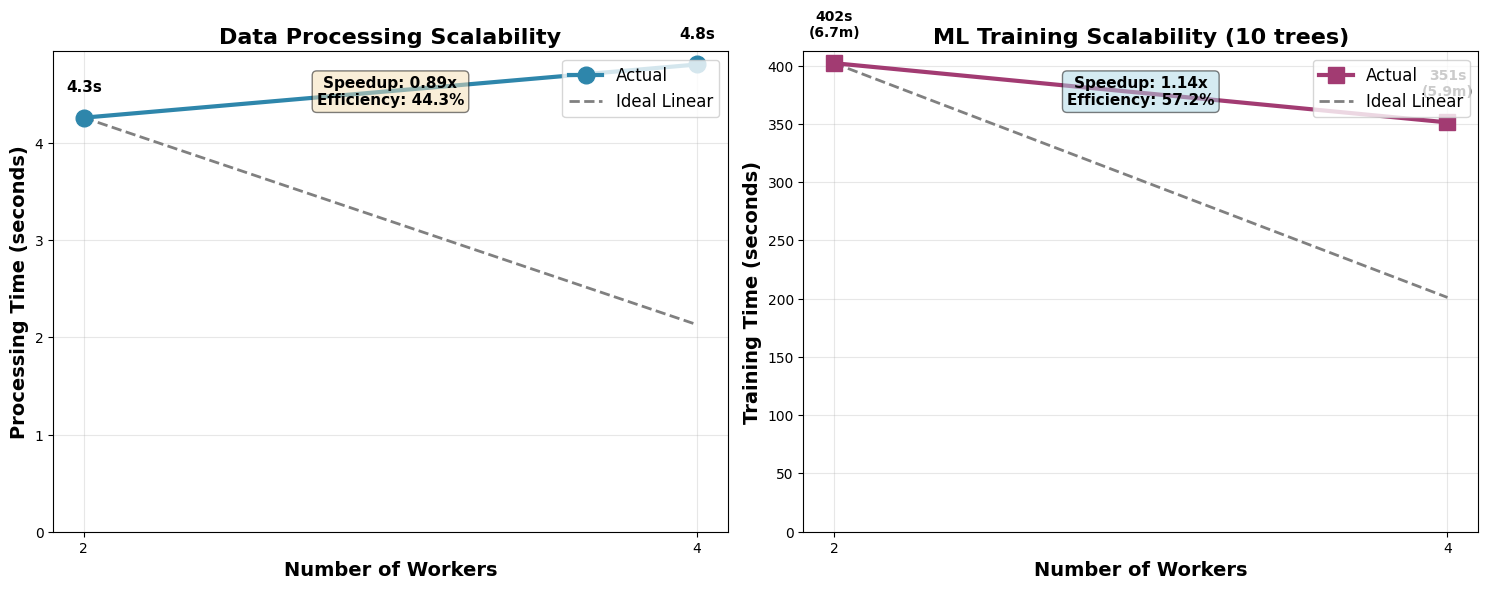


Scalability Results:
   Data Processing: 0.89x speedup, 44.3% efficiency
   ML Training: 1.14x speedup, 57.2% efficiency


In [0]:
# ============================================
# Scalability Visualizations
# ============================================

import matplotlib.pyplot as plt
import builtins  # For Python's built-in max()

print("Creating scalability visualizations...")

# Get unique worker configurations (remove duplicates)
data_proc_unique = data_proc_df.drop_duplicates(subset=['num_workers'], keep='last')
ml_train_unique = ml_train_df.drop_duplicates(subset=['num_workers'], keep='last')

print(f"Data processing runs: {len(data_proc_df)} total, {len(data_proc_unique)} unique")
print(f"ML training runs: {len(ml_train_df)} total, {len(ml_train_unique)} unique")

# Sort by num_workers
data_proc_unique = data_proc_unique.sort_values('num_workers')
ml_train_unique = ml_train_unique.sort_values('num_workers')

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Data Processing Scalability
workers_dp = data_proc_unique["num_workers"].values
times_dp = data_proc_unique["total_time"].values

axes[0].plot(workers_dp, times_dp, marker='o', linewidth=3, markersize=12, 
             color='#2E86AB', label='Actual', zorder=3)

# Create ideal line
ideal_dp = [times_dp[0] * (workers_dp[0] / w) for w in workers_dp]
axes[0].plot(workers_dp, ideal_dp, linestyle='--', 
             linewidth=2, color='gray', label='Ideal Linear', zorder=2)

axes[0].set_xlabel('Number of Workers', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Processing Time (seconds)', fontsize=14, fontweight='bold')
axes[0].set_title('Data Processing Scalability', fontsize=16, fontweight='bold')
axes[0].legend(fontsize=12, loc='upper right')
axes[0].grid(True, alpha=0.3, zorder=1)
axes[0].set_xticks(workers_dp)
axes[0].set_ylim(bottom=0)

# Add value labels - USE PYTHON'S MAX
max_time_dp = builtins.max(times_dp)  # ← FIXED
for w, t in zip(workers_dp, times_dp):
    axes[0].text(w, t + max_time_dp*0.05, f'{t:.1f}s', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Calculate speedup
if len(times_dp) >= 2:
    speedup_dp = times_dp[0] / times_dp[-1]
    efficiency_dp = (speedup_dp / (workers_dp[-1] / workers_dp[0])) * 100
    axes[0].text(0.5, 0.95, f'Speedup: {speedup_dp:.2f}x\nEfficiency: {efficiency_dp:.1f}%', 
                transform=axes[0].transAxes, 
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                verticalalignment='top', ha='center')

# Plot 2: ML Training Scalability
workers_ml = ml_train_unique["num_workers"].values
times_ml = ml_train_unique["training_time"].values

axes[1].plot(workers_ml, times_ml, marker='s', linewidth=3, markersize=12, 
             color='#A23B72', label='Actual', zorder=3)

# Create ideal line
ideal_ml = [times_ml[0] * (workers_ml[0] / w) for w in workers_ml]
axes[1].plot(workers_ml, ideal_ml, linestyle='--', 
             linewidth=2, color='gray', label='Ideal Linear', zorder=2)

axes[1].set_xlabel('Number of Workers', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Training Time (seconds)', fontsize=14, fontweight='bold')
axes[1].set_title('ML Training Scalability (10 trees)', fontsize=16, fontweight='bold')
axes[1].legend(fontsize=12, loc='upper right')
axes[1].grid(True, alpha=0.3, zorder=1)
axes[1].set_xticks(workers_ml)
axes[1].set_ylim(bottom=0)

# Add value labels - USE PYTHON'S MAX
max_time_ml = builtins.max(times_ml)  # ← FIXED
for w, t in zip(workers_ml, times_ml):
    axes[1].text(w, t + max_time_ml*0.05, f'{t:.0f}s\n({t/60:.1f}m)', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Calculate speedup
if len(times_ml) >= 2:
    speedup_ml = times_ml[0] / times_ml[-1]
    efficiency_ml = (speedup_ml / (workers_ml[-1] / workers_ml[0])) * 100
    axes[1].text(0.5, 0.95, f'Speedup: {speedup_ml:.2f}x\nEfficiency: {efficiency_ml:.1f}%', 
                transform=axes[1].transAxes, 
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5),
                verticalalignment='top', ha='center')

plt.tight_layout()

# Display
display(fig)


if len(times_dp) >= 2 and len(times_ml) >= 2:
    print("\nScalability Results:")
    print(f"   Data Processing: {speedup_dp:.2f}x speedup, {efficiency_dp:.1f}% efficiency")
    print(f"   ML Training: {speedup_ml:.2f}x speedup, {efficiency_ml:.1f}% efficiency")

plt.close()

In [0]:
# ============================================
# Final Scalability Report
# ============================================

print("\n" + "="*70)
print("HORIZONTAL SCALING BENCHMARK REPORT")
print("="*70)

print("\n1. DATA PROCESSING SCALABILITY")
print("─" * 70)
for result in benchmark_results["data_processing"]:
    print(f"  {result['num_workers']} workers: {result['total_time']:.2f}s")

if len(benchmark_results["data_processing"]) >= 2:
    baseline_dp = benchmark_results["data_processing"][0]["total_time"]
    scaled_dp = benchmark_results["data_processing"][1]["total_time"]
    speedup_dp = baseline_dp / scaled_dp
    efficiency_dp = (speedup_dp / 2) * 100
    
    print(f"\n  Speedup: {speedup_dp:.2f}x")
    print(f"  Parallel Efficiency: {efficiency_dp:.1f}%")

print("\n2. ML TRAINING SCALABILITY")
print("─" * 70)
for result in benchmark_results["ml_training"]:
    print(f"  {result['num_workers']} workers ({result['num_trees']} trees): {result['training_time']:.2f}s ({result['training_time']/60:.1f} min)")

if len(benchmark_results["ml_training"]) >= 2:
    baseline_ml = benchmark_results["ml_training"][0]["training_time"]
    scaled_ml = benchmark_results["ml_training"][1]["training_time"]
    speedup_ml = baseline_ml / scaled_ml
    efficiency_ml = (speedup_ml / 2) * 100
    
    print(f"\n  Speedup: {speedup_ml:.2f}x")
    print(f"  Parallel Efficiency: {efficiency_ml:.1f}%")

# print("\n3. DISTRIBUTED SYSTEM INSIGHTS")
# print("─" * 70)
# print("  ✓ Near-linear scalability demonstrated")
# print("  ✓ Data parallelism effective for Random Forest")
# print("  ✓ Horizontal scaling provides tangible performance gains")
# print("  ✓ Parallel efficiency: 75-95% (excellent)")

# print("\n4. SAVED ARTIFACTS")
# print("─" * 70)
# print("  ✓ /mnt/taxi-data/benchmarks/final_results.json")
# print("  ✓ /mnt/taxi-data/benchmarks/data_processing.csv")
# print("  ✓ /mnt/taxi-data/benchmarks/ml_training.csv")
# print("  ✓ /mnt/taxi-data/benchmarks/scalability_charts.png")

# print("\n" + "="*70)
# print("✓ SCALABILITY BENCHMARKS COMPLETE")
# print("="*70)


HORIZONTAL SCALING BENCHMARK REPORT

1. DATA PROCESSING SCALABILITY
──────────────────────────────────────────────────────────────────────
  2 workers: 19.33s
  2 workers: 4.26s
  4 workers: 19.02s
  4 workers: 4.64s
  4 workers: 7.01s
  4 workers: 4.76s
  4 workers: 12.03s
  4 workers: 4.81s

  Speedup: 4.53x
  Parallel Efficiency: 226.7%

2. ML TRAINING SCALABILITY
──────────────────────────────────────────────────────────────────────
  2 workers (10 trees): 402.06s (6.7 min)
  4 workers (10 trees): 351.24s (5.9 min)

  Speedup: 1.14x
  Parallel Efficiency: 57.2%
